In [ ]:
# links
https://brotherbored.com/guest-post-is-the-diplomacy-map-unbalanced/
http://ukdp.diplomatic-pouch.com/pouch/Zine/F2007R/Burton/statistician3.htm


SyntaxError: invalid syntax (<ipython-input-1-32de6015ecd0>, line 2)

In [1]:
!pip install matplotlib seaborn

In [2]:
path = ""

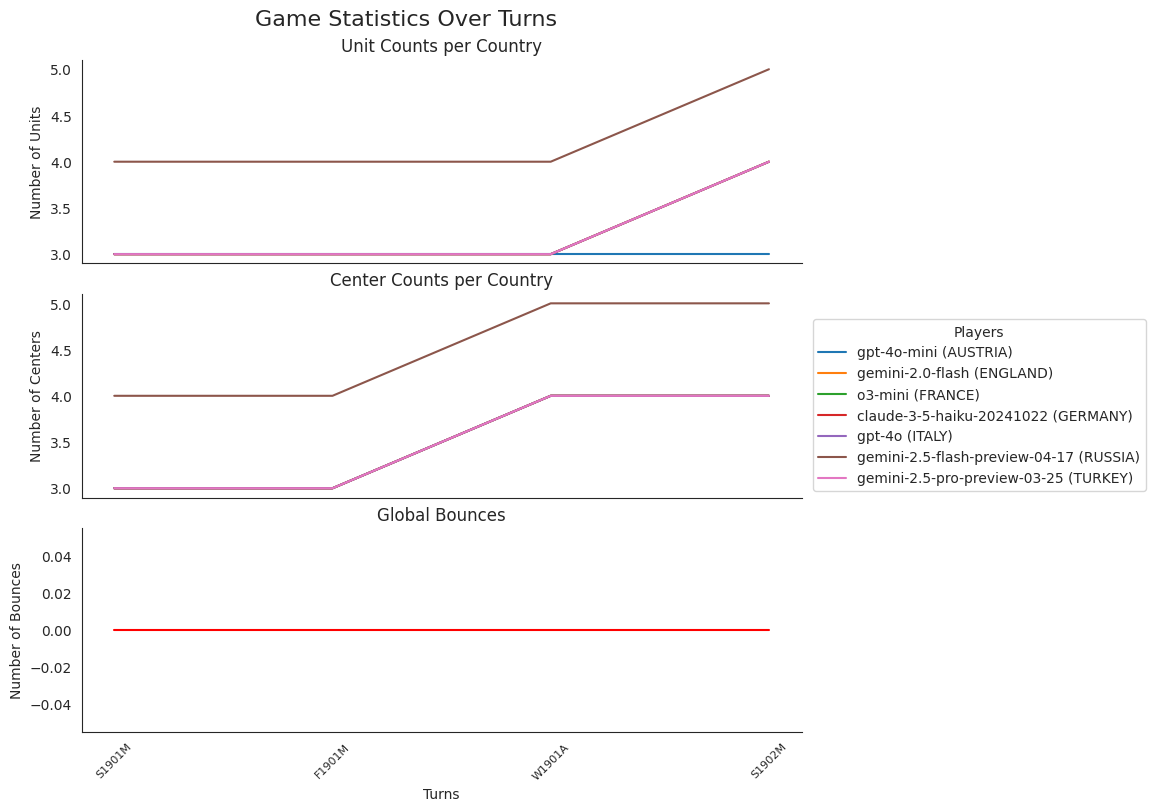

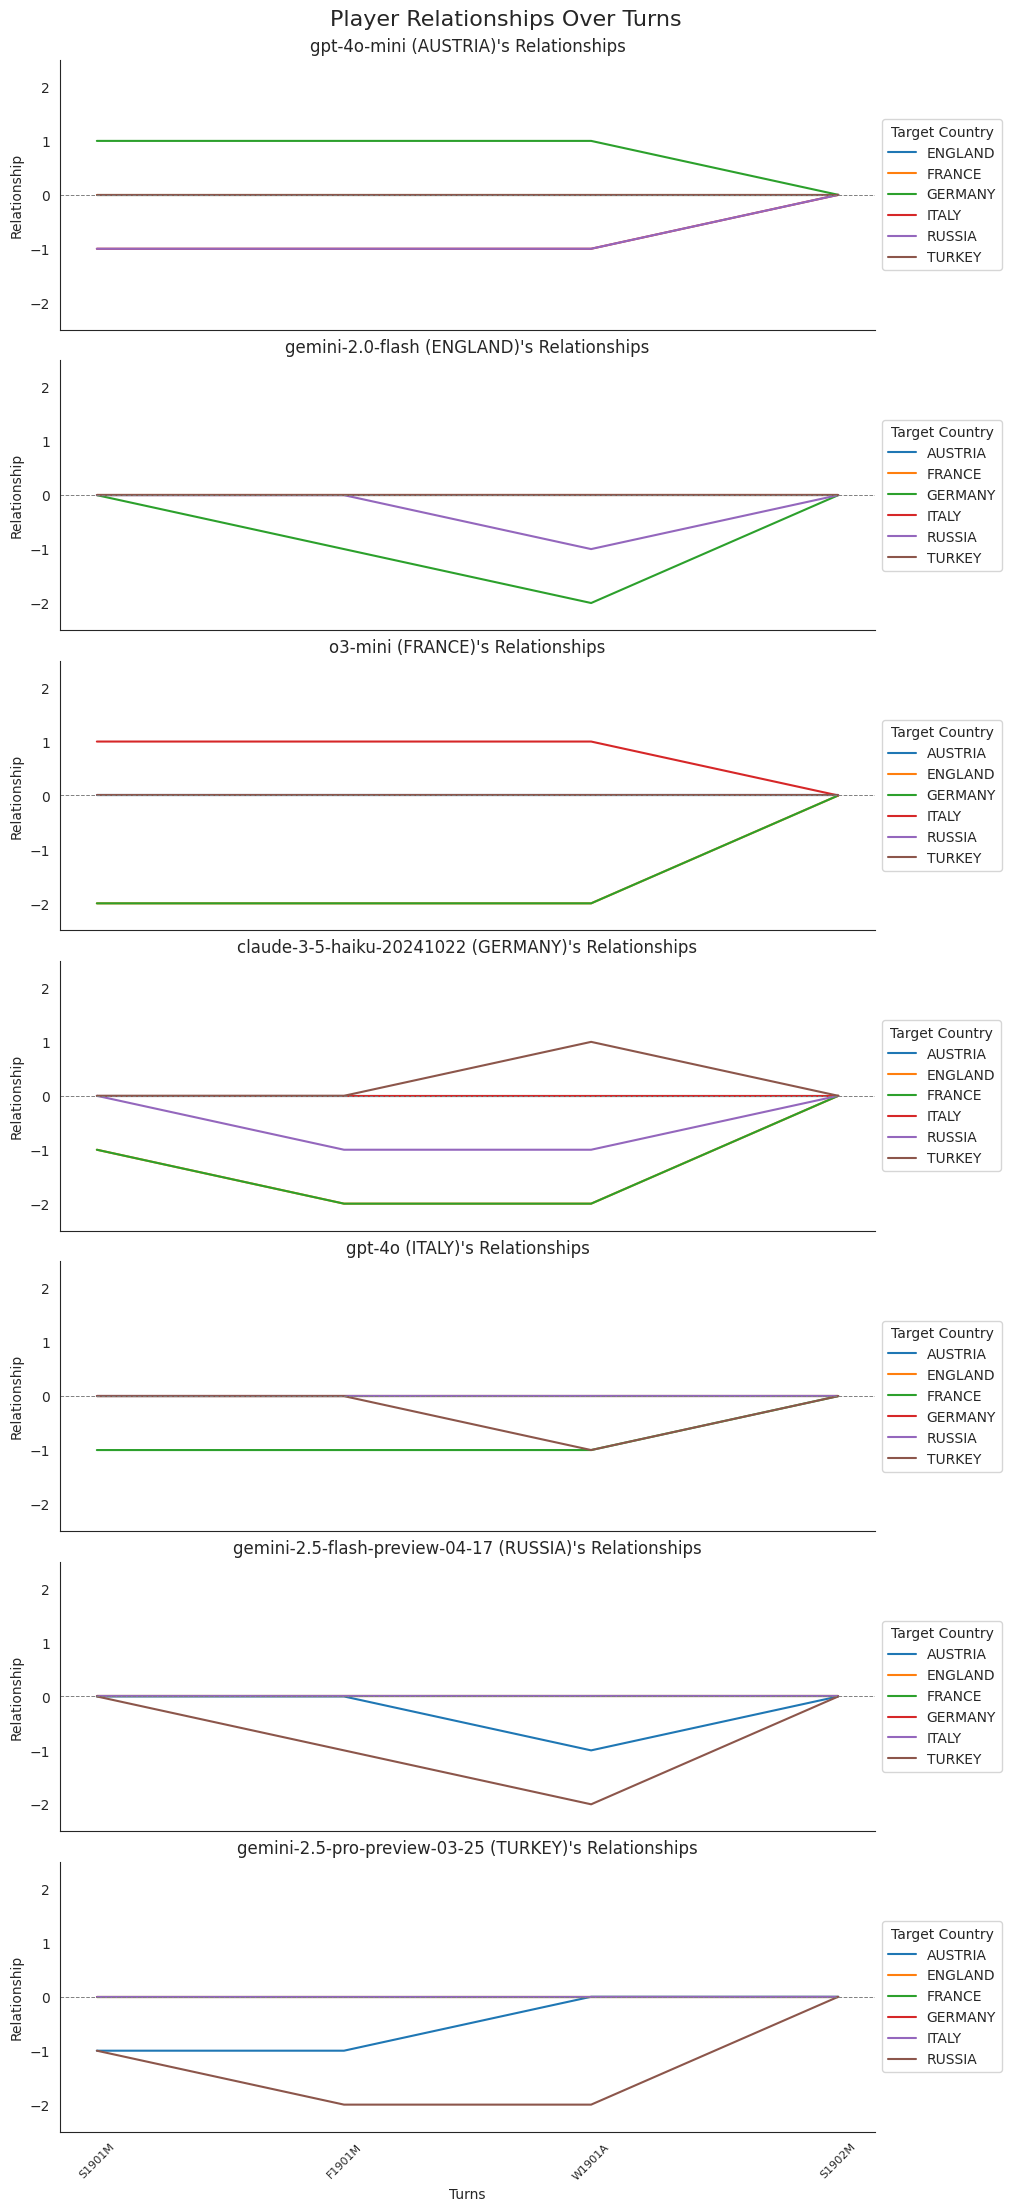

In [14]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Placeholder Setup (Adjust these) ---
# Define the path to your data files
path = "./" # e.g., '/path/to/your/data/'

# Define a mapping for relationship strings to numerical values
# (Example mapping, adjust based on your actual relationship strings)
relationship_mapping = {
    "Ally": 2,
    "Friendly": 1,
    "Neutral": 0,
    "Unfriendly": -1,
    "Enemy": -2,
    None: 0 # Handle cases where relationship might be missing or None
}
# --- End Placeholder Setup ---

# Set Seaborn style to "white"
sns.set_style("white")

# --- Data Loading with Error Handling ---
game_data_file = os.path.join(path, 'lmvsgame.json')
game_data = {}
try:
    with open(game_data_file, "r") as f:
        game_data = json.load(f)
except FileNotFoundError:
    print(f"Error: Game data file not found at {game_data_file}")
    exit()
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {game_data_file}")
    exit()

countries = ["AUSTRIA", "ENGLAND", "FRANCE", "GERMANY", "ITALY", "RUSSIA", "TURKEY"]

overview_file = os.path.join(path, 'overview.jsonl')
model_map = {}
try:
    with open(overview_file, "r") as f:
        # Assuming the model map is the second line (index 1)
        for i, line in enumerate(f):
            if i == 1:
                model_map = json.loads(line)
                # Basic validation: Check if it's a dictionary
                if not isinstance(model_map, dict):
                    print(f"Warning: Line 2 in {overview_file} is not a valid JSON dictionary. Using fallback.")
                    model_map = {} # Reset to trigger fallback
                break
    if not model_map:
        print(f"Warning: Could not load model map from {overview_file} or format was invalid. Using country names as fallback.")
        model_map = {country: country for country in countries}

except FileNotFoundError:
    print(f"Error: Overview file not found at {overview_file}. Using country names as fallback.")
    model_map = {country: country for country in countries}
except (json.JSONDecodeError, IndexError) as e:
    print(f"Error reading {overview_file}: {e}. Using country names as fallback.")
    model_map = {country: country for country in countries}

# --- Data Processing ---
turns = []
unit_counts = {country: [] for country in countries}
center_counts = {country: [] for country in countries}
conflict_counts = []
relationship_history = {country: {other_country: [] for other_country in countries} for country in countries}

for phase in game_data.get("phases", []):
    turn_name = phase.get("name", "Unknown")
    turns.append(turn_name)
    state = phase.get("state", {})

    for country in countries:
        units = state.get("units", {}).get(country, [])
        centers = state.get("centers", {}).get(country, [])
        unit_counts[country].append(len(units))
        center_counts[country].append(len(centers))

    results = phase.get("results", {})
    conflicts = sum(1 for outcome in results.values() if isinstance(outcome, str) and "bounce" in outcome.lower())
    conflict_counts.append(conflicts)

    relationships = phase.get("agent_relationships", {})
    for country in countries:
        country_relationships = relationships.get(country, {})
        for other_country in countries:
            relationship = country_relationships.get(other_country)
            numerical_relationship = relationship_mapping.get(relationship, 0)
            relationship_history[country][other_country].append(numerical_relationship)


# --- Plotting ---

# Figure 1: Unit Counts, Center Counts, Conflict Counts (SHARED LEGEND)
fig1, axs1 = plt.subplots(3, 1, figsize=(8, 8), sharex=True, constrained_layout=True)
fig1.suptitle("Game Statistics Over Turns", fontsize=16)

# Plot unit counts per country
for country in countries:
    axs1[0].plot(turns, unit_counts[country], label=f"{model_map.get(country, country)} ({country})")
axs1[0].set_title("Unit Counts per Country")
axs1[0].set_ylabel("Number of Units")
sns.despine(ax=axs1[0], top=True, right=True)

# Plot center counts per country
for country in countries:
    axs1[1].plot(turns, center_counts[country], label=f"{model_map.get(country, country)} ({country})")
axs1[1].set_title("Center Counts per Country")
axs1[1].set_ylabel("Number of Centers")
sns.despine(ax=axs1[1], top=True, right=True)

# Plot global conflict counts
axs1[2].plot(turns, conflict_counts, color="red", label="Global Bounces")
axs1[2].set_title("Global Bounces")
axs1[2].set_ylabel("Number of Bounces")
axs1[2].set_xlabel("Turns")
sns.despine(ax=axs1[2], top=True, right=True)
axs1[2].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis labels

# Create a single shared legend for Figure 1
handles, labels = axs1[0].get_legend_handles_labels() # Get from axes with all country lines
fig1.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Players")


# Figure 2: Relationship Charts (INDIVIDUAL LEGENDS)
# Adjusted figsize height slightly more for individual legends
fig2, axs2 = plt.subplots(len(countries), 1, figsize=(10, 22), sharex=True, sharey=True, constrained_layout=True)
fig2.suptitle("Player Relationships Over Turns", fontsize=16)

# Plot relationship charts for each country
for i, country in enumerate(countries):
    ax = axs2[i]
    # Update title to include model and country
    ax.set_title(f"{model_map.get(country, country)} ({country})'s Relationships")

    # Plot relationships with other countries
    plot_handles = [] # To store handles for this specific subplot's legend
    plot_labels = []  # To store labels for this specific subplot's legend
    for other_country in countries:
        if country != other_country:
            line, = ax.plot(turns, relationship_history[country][other_country], label=other_country)
            plot_handles.append(line)
            plot_labels.append(other_country)

    ax.set_ylabel("Relationship")
    sns.despine(ax=ax, top=True, right=True)

    # Add horizontal line at y=0 for reference
    ax.axhline(0, color='grey', linestyle='--', linewidth=0.7)

    # Set y-axis limits once (since sharey=True) on the first plot
    if i == 0:
        ax.set_ylim([-2.5, 2.5])

    # Create an INDIVIDUAL legend for *this* subplot (ax)
    # Sort legend items alphabetically by country name (label)
    sorted_legend_items = sorted(zip(plot_labels, plot_handles), key=lambda item: item[0])
    sorted_labels = [item[0] for item in sorted_legend_items]
    sorted_handles = [item[1] for item in sorted_legend_items]
    ax.legend(sorted_handles, sorted_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Target Country")


# Set common x-label only on the last plot
axs2[-1].set_xlabel("Turns")
axs2[-1].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis labels

# Display the plots
plt.show()